In [33]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_kddcup99
from math import sqrt
#from functions import *
import pickle
import os
import pprint

In [ ]:
'''
import sys
if 'sklearn' not in sys.modules:
   ! pip install scikit-learn
'''

In [2]:

###### FUNCTIONS #######
def average(iterable):
    mean=sum(iterable)/len(iterable)
    std=sqrt(sum([(el-mean)**2 for el in iterable])/len(iterable))
    return mean, std

def labelToInt(label):
    """
    Let's define a map from Y (set of strings) into (0,size(Y)) for easier usage
    """
    uniqueLabels=list(np.unique(y))
    return uniqueLabels.index(label)


def deleteBytes(datum):
    x = datum[1]["x"]
    mask = [type(i) != bytes for i in x]
    datum[1]["x"] = np.asarray(x[mask])
    #print(x)
    #print(mask)
    return datum
    
def localPlusPlusInit(points, k, logDict=None): 
    #print('pointsshape: ', points.shape)
    '''
    Initialization kmeans ++
    points is a numpy array (n,dim)
    '''
    t0 = time()

    
    C=points[np.random.choice(points.shape[0])]#sample from array di punti ecc...
    C=C[np.newaxis, :]

    tSamples = []
    tCentroids = []
    
    for _ in range(k-1):
        #points is array (n, dim), C is array(g<=k, dim)
        #probs is array (n,1)
        t1=time()
        
        probs=np.min(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1).flatten()
        #probs=[min([sum((point-centroid)**2) for centroid in C]) for point in points] #numpyfy this, or numbafy if left base python
        probs=probs/np.sum(probs)
        nextCentroid=points[np.random.choice(points.shape[0], p=probs)][np.newaxis,:]
        #print('LE FORME',C.shape, nextCentroid.shape)

        t2=time()
        
        C=np.vstack((C, nextCentroid))

        t3=time()
        tSample = t2 -t1
        tCentroid = t3 - t2
        tSamples.append(tSample)
        tCentroids.append(tCentroid)
        

    tEnd=time()
    if logDict is not None:
        logDict["tSamples"] = tSamples
        logDict["tCentroids"] = tCentroids
        logDict["tTotal"] = tEnd - t0
    
    return C


def weightedAverage(group):
    """
    Function to compute the weighted average
    """
    weight_column='weights'
    groupby_column='clusterId'
    columns_to_average = group.columns.difference([weight_column, groupby_column])
    weighted_averages = group[columns_to_average].multiply(group[weight_column], axis=0).sum() / group[weight_column].sum()
    return weighted_averages


def localLloyds(points, k, C_init=None, weights=None, n_iterations=100, logDict=None):
    """
    Local (non-distributed) Lloyds algorithm
    Arguments:
    `points`: array (n, dim) of points to cluster;
    `k`: number of desired clusters;
    `C_init`: optional, array (k, dim) of initial centroids
    `weights`: optional, weights for weighted average in centroid re-computing;
    `n_iterations`: optional, number of iteration in lloyds algorithm;
    Return:
    array of best centroids computed.
    """
    t0 = time()
    
    my_kMeansCosts = []
    tIterations = []
    
    df=pd.DataFrame(points)
    if weights is None:
        weights=np.ones(shape=len(points))
    #print('weights', weights)
    df['weights']=weights
    df['clusterId']=np.zeros(shape=len(points))
    if C_init is None:
        C=localPlusPlusInit(points, k)
    else:
        C=C_init
    #print('localPlusPluisInit: ', C)
    clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1)
    for iteration in range(n_iterations):
        t1=time()
        
        df['clusterId']=clusterId
        C_df=df.groupby('clusterId')\
            .apply(weightedAverage)\
            .reset_index()
        C_array=C_df[C_df.columns.difference(['weights', 'clusterId'])].reset_index(drop=True).to_numpy()
        squared_distances=np.sum((points[:,:,np.newaxis]-C_array.T[np.newaxis,:,:])**2, axis=1)
        clusterId=np.argmin(squared_distances, axis=1)
        my_cost=sum(squared_distances[np.arange(len(squared_distances)), clusterId])
        #print(clusterId)

        my_kMeansCosts.append(my_cost)
        t2 = time()
        
        tIteration = t2 - t1
        tIterations.append(tIteration)

    tEnd = time()
    tTotal = tEnd - t0
    
    if logDict is not None:
        logDict["CostsKmeans"] = my_kMeansCosts
        logDict["tIterations"] = tIterations
        logDict["tTotal"] = tTotal
    
    return C_array   


def minmaxRescale(datum, minS, maxS):
    """
    Rescale a datum in [0,1]
    """
    mask = np.array(minS < maxS).astype(bool)
    feature = datum[1]["x"] 
    feature = (feature[mask] - minS[mask])/(maxS[mask] - minS[mask])
    return (datum[0], {"x": feature, "y": datum[1]["y"], "d2":datum[1]["d2"]}) 


def selectCluster(datum, C, updateDistances=True):
    """
    Associates a datum to its centroid and updates the distance if True
    dimC(k, len(datum))
    """
    distances = np.sum((datum[1]["x"] - C)**2, axis=1)
    print('distances: ',distances)
    clusterId = np.argmin(distances)
    if updateDistances is True:
        return (clusterId, {'x':datum[1]['x'], 'y':datum[1]['y'], 'd2':distances[clusterId]})
    else:
        return (clusterId, datum[1])


def updateCentroids(Rdd):
    """
    update centroids as 'centers of mass' of clusters
    """
    C=Rdd.mapValues(lambda xy: (xy['x'], 1))\
              .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
              .mapValues(lambda a:a[0]/a[1])\
              .values()\
              .collect() 
    C=np.array(C) #check later more carefully if causes some overhead
    return C


def updateDistances(Rdd, C):
    """
    update the Rdd with square distances from centroids, given Rdd with centroids already updated
    """
    def datumUpdate(datum, C):
        d2=np.sum((datum[1]['x']-C[datum[0]])**2)
        #return datum
        return (datum[0], {"x": datum[1]["x"], "y": datum[1]["y"], "d2":d2})
    Rdd=Rdd.map(lambda datum:datumUpdate(datum, C))
    return Rdd


def cost(Rdd):
    """
    calculate global cost of X,C from an Rdd with distances from centroids already updated
    """
    my_cost=Rdd.map(lambda datum : datum[1]['d2'])\
               .reduce(lambda a,b: a+b)
    return my_cost 


def kMeans(Rdd, C_init, maxIterations, logParallelKmeans=None):
    """
    kMeans in parallel (?)
    """
    
    t0 = time()
    
    my_kMeansCosts = []
    tIterations = []
    C=C_init

    for t in range(maxIterations):
        t1 = time()
        RddCached = Rdd.map(lambda datum: selectCluster(datum, C)).persist()
        # Now we compute the new centroids by calculating the averages of points belonging to the same cluster.
        # Need to check that all centroids are assigned to at least one point, otherwise k changes!!! Solutions?!
        C=updateCentroids(RddCached)
        my_cost = cost(RddCached)
        
        my_kMeansCosts.append(my_cost)
        t2 = time()
        
        tIteration = t2 - t1
        tIterations.append(tIteration)
        
        #RddCached.unpersist() bad for time efficiency, not necessary due to Python Garbage collector
        

    tEnd = time()
    tTotal = tEnd - t0
    
    if logParallelKmeans is not None:
        logParallelKmeans["CostsKmeans"] = my_kMeansCosts
        logParallelKmeans["tIterations"] = tIterations
        logParallelKmeans["tTotal"] = tTotal
        
    return C


def naiveInitFromSet(Rdd, k, logNaiveInit=None):
    """
    uniform sampling of k points from Rdd
    """
    t0 = time()
    
    kSubset=Rdd.takeSample(False, k)
    # Replacement is set to False to avoid coinciding centroids BUT no guarantees that in the original dataset all points are distinct!!! Check if causes problems in the algorithm (i.e. need to pre-filter) or it's ok
    C_init=np.array([datum[1]['x'] for datum in kSubset])

    tEnd = time()
    
    if logNaiveInit is not None:
        logNaiveInit["tTotal"] = tEnd - t0
        
    return C_init


def naiveInitFromSpace(k, dim):
    """
    #uniform drawing of k points from euclidean space
    #we assume the Rdd has been mapped into a [0,1]^dim space
    """
    C_init=np.random.uniform(size=(k,dim))
    return C_init


def parallelInit(Rdd, k, l, logParallelInit=None):
    """
    Parallel initialization
    """
    t0 = time()
    
    # initialize C as a point in the dataset
    C=naiveInitFromSet(Rdd, 1) 
    
    # associate each datum to the only centroid (computed before) and computed distances and cost
    Rdd=Rdd.map(lambda datum : (0, datum[1]))
    Rdd=updateDistances(Rdd, C).persist()
    my_cost=cost(Rdd)

    # number of iterations (log(cost))
    n_iterations=int(np.log(my_cost))
    if(n_iterations<1): n_iterations=1

    
    tSamples = []
    tCentroids = []
    CostInits = [my_cost]
    # iterative sampling of the centroids
    for _ in range(n_iterations):

        t1=time()
        # sample C' according to the probability
        C_prime=Rdd.filter(lambda datum : np.random.uniform()<l*datum[1]['d2']/my_cost)\
                   .map(lambda datum : datum[1]['x'])\
                   .collect()
        C_prime=np.array(C_prime)
        t2=time()

        # stack C and C', update distances, centroids, and cost
        if (C_prime.shape[0]>0):
            C=np.vstack((C, C_prime))
            Rdd=Rdd.map(lambda datum: selectCluster(datum, C)).persist()
            my_cost=cost(Rdd)
        t3=time()

        tSample = t2 -t1
        tCentroid = t3 - t2
        tSamples.append(tSample)
        tCentroids.append(tCentroid)
        CostInits.append(my_cost)
       
    #erase centroids sampled more than once 
    C=C.astype(float)
    C=np.unique(C, axis=0)
    Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
    
    #compute weights of centroids (sizes of each cluster) and put them in a list whose index is same centroid index as C
    wx=Rdd.countByKey()
    weights=np.zeros(len(C))
    weights[[list(wx.keys())]]=[list(wx.values())]
    
    #subselection of k centroids from C, using local Lloyds algorithm with k-means++ initialization
    if C.shape[0]<=k:
        C_init=C
    else:
        C_init=localLloyds(C, k, weights=weights, n_iterations=100)

    tEnd = time()
    
    if logParallelInit is not None:
        logParallelInit["tSamples"] = tSamples
        logParallelInit["tCentroids"] = tCentroids
        logParallelInit["CostInit"] = CostInits
        logParallelInit["tTotal"] = tEnd - t0
        
    return C_init

def predictedCentroidsLabeler(C_expected, C_predicted):
    distMatrix=np.sum((C_expected[:,:,np.newaxis]-C_predicted.T[np.newaxis, :,:])**2,axis=1)
    #the labeler i-th entry j, tells that i-th centroid of C_expected is associated to j-th element of C_predicted
    labeler=np.argmin(distMatrix,axis=1)
    #square distance of element of C_expected to nearest point in C_predicted
    distances=np.sqrt(np.array(distMatrix[np.arange(len(distMatrix)),labeler]).astype(float))
    return labeler, distances

def nearestCentroidDistances(C):
    distMatrix=np.sum((C[:,:,np.newaxis]-C.T[np.newaxis, :,:])**2,axis=1)
    distMatrix+=np.diag(np.repeat(np.inf, distMatrix.shape[0]))
    #the labeler i-th entry j, tells that i-th centroid of C_expected is associated to j-th element of C_predicted
    labeler=np.argmin(distMatrix,axis=1)
    #square distance of element of C_expected to nearest point in C_predicted
    distances=np.sqrt(np.array(distMatrix[np.arange(distMatrix.shape[0]),labeler]).astype(float))
    return labeler, distances

# SET UP SPARK

In [3]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

24/07/07 17:32:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# create a spark context
sc = spark.sparkContext
sc.setLogLevel("ERROR")

### Fetch dataset

In [5]:
data = fetch_kddcup99(return_X_y = True, percent10 = True) # default percent10=True


In [ ]:
# collect samples and features (target)
x = data[0]
y = data[1] 

In [ ]:
# optional shuffling for better exploration of subset of dataset
shuffling=True

if shuffling:
    shuffled_indices = np.random.permutation(len(y))
    x=x[shuffled_indices]
    y=y[shuffled_indices]

In [ ]:
# cut the data for memory reasons
subLen = 40000
x = x[:subLen,]
y = y[:subLen]

In [ ]:
nSlice = None # IMPORTANT PARAMETER FOR NUMBER OF PARTITIONS
Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(len(y))], numSlices = nSlice)

In [ ]:
Rdd.getNumPartitions() # check partitions

In the following cells, the attributes of the dataset:

In [ ]:
attributes = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate"
]

Check the symbolic variables in the dataset to have only useful data

In [ ]:
RddX = Rdd.map(lambda datum: datum[1]["x"]).persist()
typeElement = RddX.map(lambda x: [set([type(x[i])]) for i in range(len(x))])\
                  .reduce(lambda a, b: [a[i].union(b[i]) for i in range(len(a))])

In [ ]:
types_str = [str(t) for t in typeElement]
# Create a table
fig, ax = plt.subplots()

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table_data = [[attributes[i], types_str[i]] for i in range(len(types_str))]
column_labels = ("Index", "Type")
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')

# Adjust the table
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.2, 1.2)


Look for the unique variables over the attributes using parallel processing

In [ ]:
%%time
uniquesParallel = []
for i in range(41):
    s = RddX.map(lambda x: x[i])\
        .distinct()\
        .count()
    uniquesParallel.append(s)

RddX.unpersist()

In [ ]:
print("The number of uniques is", uniquesParallel)

Look for the unique variables over the attributes in local

In [ ]:
%%time
uniques = []
for i in range (x.shape[1]):
    k = (len(np.unique(x[:, i])))
    uniques.append(k)
print("The uniques are:", uniques)

It takes 4 times for to do it in parallel (explain what is better to use)

why running it a second time takes way more time?

In [ ]:
%%time
RddY = Rdd.map(lambda datum: datum[1]["y"]).persist()

kTrue = RddY.distinct()\
        .count()

In [ ]:
print("The true number of the classes is", kTrue)

Unique number of labels in parallel

In [ ]:
%%time
uniquesParallely = RddY.countByValue()
RddY.unpersist()

print("The y things are:", uniquesParallely)

In [ ]:
yUnique = [a.decode('utf-8') for a in uniquesParallely.keys()]
xUnique = list(uniquesParallely.values())

Plot of the count of the ocurency of the uniques of label and attributes

In [ ]:
# add log 10 the ax and npt the count
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].barh(yUnique, np.log10(xUnique))
ax[0].set_xlabel("log10 count")
ax[0].set_ylabel("Label")
ax[0].set_title("Label count")
ax[1].barh(attributes, np.log10(uniquesParallel))
ax[1].set_xlabel("log10 count")
ax[1].set_ylabel("Attribute")
ax[1].set_title("Attribute count")
fig.tight_layout()

In [ ]:
Rdd = Rdd.map(deleteBytes)\
         .persist()

In [ ]:
numberColumns = len([i for i in typeElement if i != set([bytes])])
print("The number of columns (dimensionality) after filtering the bytes is", numberColumns)

# PARALLEL PART

In [ ]:
%%time
maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))\
         .persist()

In [ ]:
%%time

logParallelInit = {}
logParallelKmeans = {}

k=kTrue
l=k*2 # rescaling probability to have more centroids than k

# inizialize the centroids with kmeans parallel and compute C after the iterations
C_init = parallelInit(Rdd, k, l, logParallelInit)
C = kMeans(Rdd, C_init, 15, logParallelKmeans)
Rdd=Rdd.map(lambda datum: selectCluster(datum, C))

In [ ]:
fig, ax=plt.subplots(1,3, figsize=(15,10))
ax[0].plot(logParallelInit["tCentroids"])
ax[1].plot(logParallelInit["tSamples"])
ax[2].plot(logParallelInit["CostInit"])

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(logParallelKmeans["tIterations"])
ax[1].plot(logParallelKmeans["CostsKmeans"])

# AGREEMENT BETWEEN EXPECTED CLUSTER LABELS Y AND RESULTED LABELS CLUSTERID

In [ ]:
C_predicted=C
expectedRdd=Rdd.map(lambda datum:(labelToInt(datum[1]['y']), datum[1])) #put y-label as clusterId
C_expected=updateCentroids(expectedRdd) #compute centroids coordinate
expectedRdd=updateDistances(expectedRdd, C_expected) #update and save squared distances points-centroids
print(expectedRdd.take(1))

First, we compare the cluster populations

In [ ]:
predictedPopulationDict=Rdd.countByKey()
predictedPopulationDict = dict(sorted(predictedPopulationDict.items(), key=lambda item: item[1], reverse=True))
expectedPopulationDict=Rdd.map(lambda datum:(datum[1]['y'], datum[1])).countByKey()
expectedPopulationDict = dict(sorted(expectedPopulationDict.items(), key=lambda item: item[1], reverse=True))
print('predictedPopulationDict', predictedPopulationDict)
plt.bar(np.arange(len(predictedPopulationDict)), predictedPopulationDict.values())
plt.show()
print('expectedPopulationDict',expectedPopulationDict)
plt.bar(np.arange(len(expectedPopulationDict)), expectedPopulationDict.values())
plt.show()

Now we want to calculate the mean square error between expected centroids and the nearest predicted centroids.

In [ ]:
print('k_expected, k_predicted: ', len(C_expected), len(C_predicted))

labeler, distancesPredictedExpected=predictedCentroidsLabeler(C_expected, C_predicted)
meanSquaredError=np.sum(distancesPredictedExpected**2)/len(distancesPredictedExpected)
print('Index of nearest predicted centroid to each expected centroid: \n', labeler)
print('Distances between expected centroids and nearest predicted centroids: \n', distancesPredictedExpected)
print('MeanSquaredError: ', meanSquaredError)

In [ ]:
#standard deviation of cluster from expected centroids
#stdExpected=updateDistances(Rdd.map(lambda datum: (datum[1]['y'], datum[1])), C_expected).collect()
stdExpected=expectedRdd.mapValues(lambda datum1: (datum1['d2'], 1))\
                        .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
                        .mapValues(lambda a:np.sqrt(a[0]/a[1]))\
                        .collect()
stdExpected=list(zip(*stdExpected))
print(stdExpected)

In the following plot we show:
- with blue errorbars the standard deviation of expected cluster with respect to expected centroids;
- with blue boxes the distances to each expected centroid of its nearest **expected** centroid
- with red bars the distances to each expected centroid of its nearest **predicted** centroid;

In [ ]:
plt.errorbar(np.arange(len(C_expected)), np.zeros(shape=(len(stdExpected[0]))), stdExpected[1])
print(distancesPredictedExpected)
plt.bar(np.arange(len(C_expected)), distancesPredictedExpected, color='red')
plt.bar(np.arange(len(C_expected)), nearestCentroidDistances(C_expected)[1], edgecolor='blue', facecolor='none')

### TESTING LOCAL KMEANS++ VS KMEANS// WITH A SMALL DATASET

In [11]:
# collect samples and features (target)
x = data[0]
y = data[1] 

In [12]:
# optional shuffling for better exploration of subset of dataset
shuffling=True
if shuffling:
    shuffled_indices = np.random.permutation(len(y))
    x=x[shuffled_indices]
    y=y[shuffled_indices]

In [13]:
# cut the data for memory reasons
subLen = 100
x = x[:subLen,]
y = y[:subLen]

In [14]:
kTrue = len(np.unique(y))

In [15]:
k=kTrue

### First case - distributed - with initialization: kMeans//

In [20]:
# setting up some dictionaries
totalLogKmeansParallel = {}
totalLogInitParallel= {}
tDurationsParallel = {}
tPreOperationsParallel = {}

n_samples=5
for i_sample in range(n_samples):

    tInit = time() # compute the time of the beginning of the iteration
    print(f"The iteration n {i_sample} started at time {tInit}")
    
    # parallelize over nSlice partitions
    Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(len(y))])

    # cut the categorical attributes
    Rdd = Rdd.map(deleteBytes)\
             .persist()

    # setting the theoretical number of clusters
    kTrue = Rdd.map(lambda datum: datum[1]["y"])\
               .distinct()\
               .count()
    
    # rescale the RDD over the max
    maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
    minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

    Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))\
             .persist()
    
    # setting up the input and output information for the alghoritm
    logInit = {}
    logKmeans = {}

    k=kTrue
    l=k*2 # rescaling probability to have more centroids than k

    tInitI = time()

    tPreOperation = tInitI - tInit
    print(f"Finished the pre-steps after {tPreOperation} seconds")
          
    # initialization kMeans //
    C_init = parallelInit(Rdd, k, l, logInit)
    
    tInitialization = time() - tInitI
    print(f"Finished the initialization after {tInitialization} seconds")
    
    # run the k-means alghoritm
    C = kMeans(Rdd, C_init, 15, logKmeans)
    
    # time information
    tEnd = time() # compute the time of the end of the iteration over the number of partitions
    tDuration = tEnd - tInit
    
    print(f"The iteration n {i_sample} ended at time {tEnd} after {tDuration} seconds")

    # output in the correct memory adresses
    totalLogInitParallel[i_sample] = logInit
    totalLogKmeansParallel[i_sample] = logKmeans
    tDurationsParallel[i_sample] = tDuration
    tPreOperationsParallel[i_sample] = tPreOperation

The iteration n 0 started at time 1720373806.1049035
Finished the pre-steps after 0.6117491722106934 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Finished the initialization after 2.9725453853607178 seconds


The iteration n 0 ended at time 1720373819.9889648 after 13.884061336517334 seconds
The iteration n 1 started at time 1720373819.989222
Finished the pre-steps after 0.47306370735168457 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Finished the initialization after 3.0171806812286377 seconds
The iteration n 1 ended at time 1720373830.2633035 after 10.274081468582153 seconds
The iteration n 2 started at time 1720373830.2633867
Finished the pre-steps after 0.5597829818725586 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Finished the initialization after 2.95676589012146 seconds
The iteration n 2 ended at time 1720373839.903244 after 9.639857292175293 seconds
The iteration n 3 started at time 1720373839.9033206
Finished the pre-steps after 0.5058276653289795 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Finished the initialization after 2.8150737285614014 seconds
The iteration n 3 ended at time 1720373849.1525645 after 9.249243974685669 seconds
The iteration n 4 started at time 1720373849.1526444
Finished the pre-steps after 0.5025177001953125 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Finished the initialization after 3.176295518875122 seconds
The iteration n 4 ended at time 1720373859.141865 after 9.98922061920166 seconds


In [35]:
pprint.pprint(totalLogInitParallel)

{0: {'CostInit': [345.2529924890628,
                  21.854864860918322,
                  1.6530770105287251,
                  0.1553612973987495,
                  0.007843879830841867,
                  0.0],
     'tCentroids': [0.16808605194091797,
                    0.2216954231262207,
                    0.1907365322113037,
                    0.21411705017089844,
                    0.2216804027557373],
     'tSamples': [0.12043905258178711,
                  0.09229493141174316,
                  0.11748743057250977,
                  0.11132431030273438,
                  0.10136556625366211],
     'tTotal': 2.9724366664886475},
 1: {'CostInit': [830.194265985248,
                  74.40248396647166,
                  4.021854329255521,
                  0.2887370787434806,
                  0.018471789001927322,
                  0.0002493742595077242,
                  0.0],
     'tCentroids': [0.15521550178527832,
                    0.18305563926696777,
               

NameError: name 'minLenTCentroids' is not defined

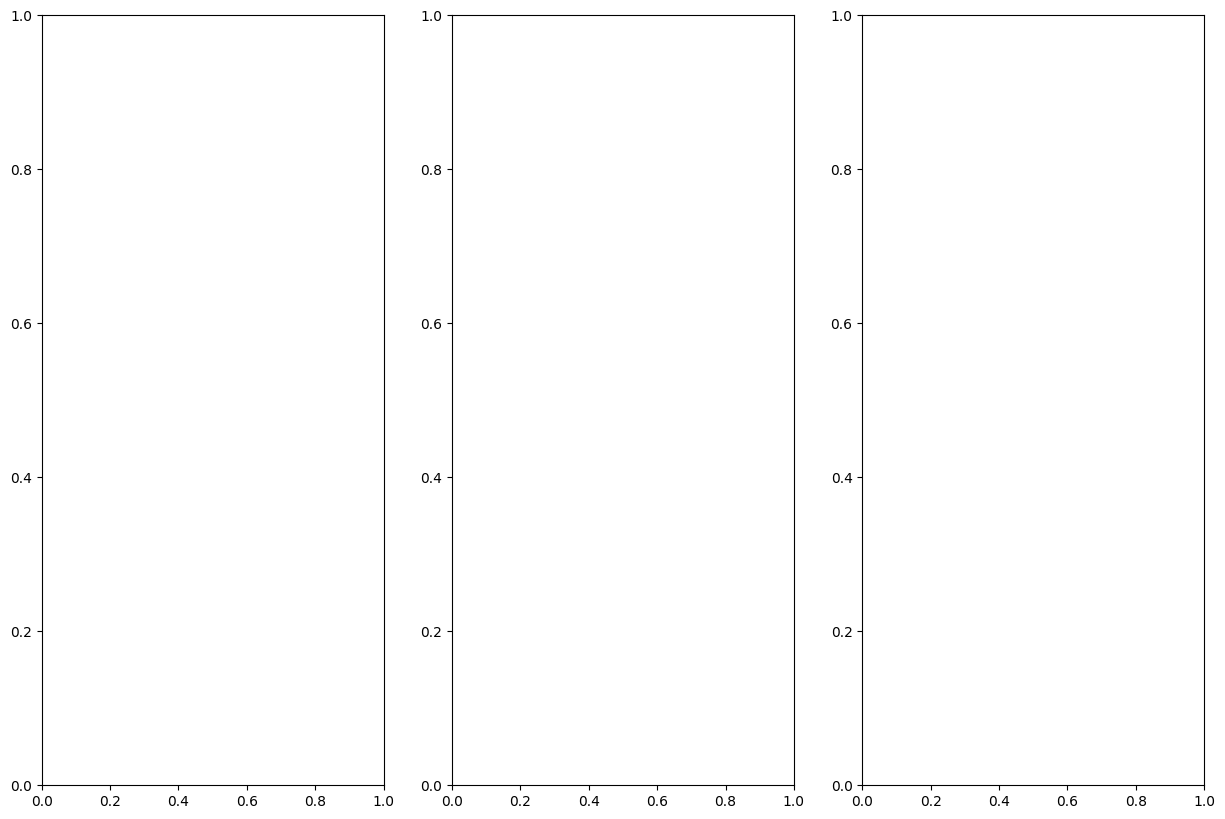

In [40]:
fig, ax=plt.subplots(1,3, figsize=(15,10))
minLenTCentroids
minLenTSamples
ax[0].plot(np.array([totalLogInitParallel[i]["tCentroids"][:minLenTCentroids] for i in range(n_samples)]).mean(axis=1))
ax[1].plot(np.array([totalLogInitParallel[i]["tSamples"][:minLenTCentroids] for i in range(n_samples)]).mean(axis=1))
ax[2].plot(np.array([totalLogInitParallel[i]["CostsKmeans"] for i in range(n_samples)]).mean(axis=1))
#ax[2].plot(logParallelInit["CostInit"])

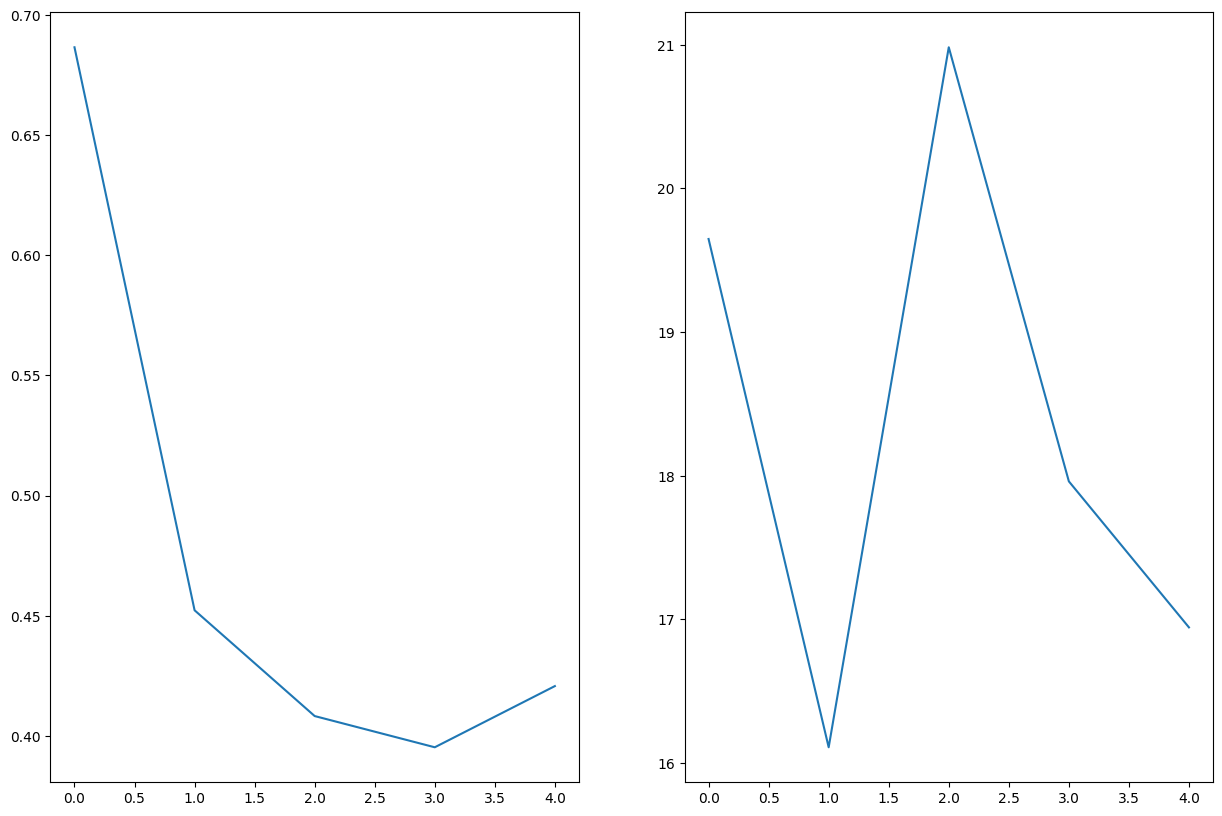

In [24]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(np.array([totalLogKmeansParallel[i]["tIterations"] for i in range(n_samples)]).mean(axis=1))
ax[1].plot(np.array([totalLogKmeansParallel[i]["CostsKmeans"] for i in range(n_samples)]).mean(axis=1))

### Second case - local - with initialization: kMeans++

In [27]:
# setting up some dictionaries
totalLogKmeansPlusPlus = {}
totalLogInitPlusPlus= {}
tDurationsPlusPlus = {}
tPreOperationsPlusPlus = {}

n_samples=5
for i_sample in range(n_samples):

    tInit = time() # compute the time of the beginning of the iteration over the number of partitions
    print(f"The iteration n {i_sample} number of partition started at time {tInit}")
    
    # change format for processing
    localD =np.array([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(len(y))])

    # cut the categorical attributes

    localD =np.array(list(map(deleteBytes, localD)))
    
    localDX=np.array(list(map(lambda datum: datum[1]["x"], localD))).astype(float)
    
    # rescale the RDD over the max
    maxS = localDX.max(axis=0)
    minS = localDX.min(axis=0)

    localD = np.array(list(map(lambda datum: minmaxRescale(datum, minS, maxS), localD)))
    
    # setting up the input and output information for the alghoritm
    logInit = {}
    logKmeans = {}

    k=kTrue
    l=k*2 # rescaling probability to have more centroids than k

    tInitI = time()

    tPreOperation = tInitI - tInit
    print(f"Finished the pre-steps after {tPreOperation} seconds")
          
    # initialization kMeans //
    print(localDX.shape[0])
    C_init = localPlusPlusInit(localDX, k, logInit)
    
    tInitialization = time() - tInitI
    print(f"Finished the initialization after {tInitialization} seconds")
    
    # run the k-means alghoritm
    C =  localLloyds(localDX, k, C_init=C_init, n_iterations=100, logDict=logKmeans)
    
    # time information
    tEnd = time() # compute the time of the end of the iteration over the number of partitions
    tDuration = tEnd - tInit
    
    print(f"The iteration n. {i_sample} ended at time {tEnd} after {tDuration} seconds")

    # output in the correct memory adresses
    totalLogInitPlusPlus[i_sample] = logInit
    totalLogKmeansPlusPlus[i_sample] = logKmeans
    tDurationsPlusPlus[i_sample] = tDuration
    tPreOperationsPlusPlus[i_sample] = tPreOperation

The iteration n 0 number of partition started at time 1720374189.248991
Finished the pre-steps after 0.002450227737426758 seconds
100
Finished the initialization after 0.001203298568725586 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

The iteration n. 0 ended at time 1720374189.980051 after 0.7310600280761719 seconds
The iteration n 1 number of partition started at time 1720374189.980091
Finished the pre-steps after 0.0018031597137451172 seconds
100
Finished the initialization after 0.0007650852203369141 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

The iteration n. 1 ended at time 1720374190.7103455 after 0.7302544116973877 seconds
The iteration n 2 number of partition started at time 1720374190.7103815
Finished the pre-steps after 0.002366304397583008 seconds
100
Finished the initialization after 0.0006437301635742188 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

The iteration n. 2 ended at time 1720374191.4348402 after 0.7244586944580078 seconds
The iteration n 3 number of partition started at time 1720374191.4348788
Finished the pre-steps after 0.0017819404602050781 seconds
100
Finished the initialization after 0.0007219314575195312 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

The iteration n. 3 ended at time 1720374192.1645408 after 0.7296619415283203 seconds
The iteration n 4 number of partition started at time 1720374192.1646993
Finished the pre-steps after 0.0021049976348876953 seconds
100
Finished the initialization after 0.0006401538848876953 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

The iteration n. 4 ended at time 1720374192.892296 after 0.7275967597961426 seconds


/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_129770/2721140029.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

In [36]:
pprint.pprint(totalLogInitParallel)

{0: {'CostInit': [345.2529924890628,
                  21.854864860918322,
                  1.6530770105287251,
                  0.1553612973987495,
                  0.007843879830841867,
                  0.0],
     'tCentroids': [0.16808605194091797,
                    0.2216954231262207,
                    0.1907365322113037,
                    0.21411705017089844,
                    0.2216804027557373],
     'tSamples': [0.12043905258178711,
                  0.09229493141174316,
                  0.11748743057250977,
                  0.11132431030273438,
                  0.10136556625366211],
     'tTotal': 2.9724366664886475},
 1: {'CostInit': [830.194265985248,
                  74.40248396647166,
                  4.021854329255521,
                  0.2887370787434806,
                  0.018471789001927322,
                  0.0002493742595077242,
                  0.0],
     'tCentroids': [0.15521550178527832,
                    0.18305563926696777,
               

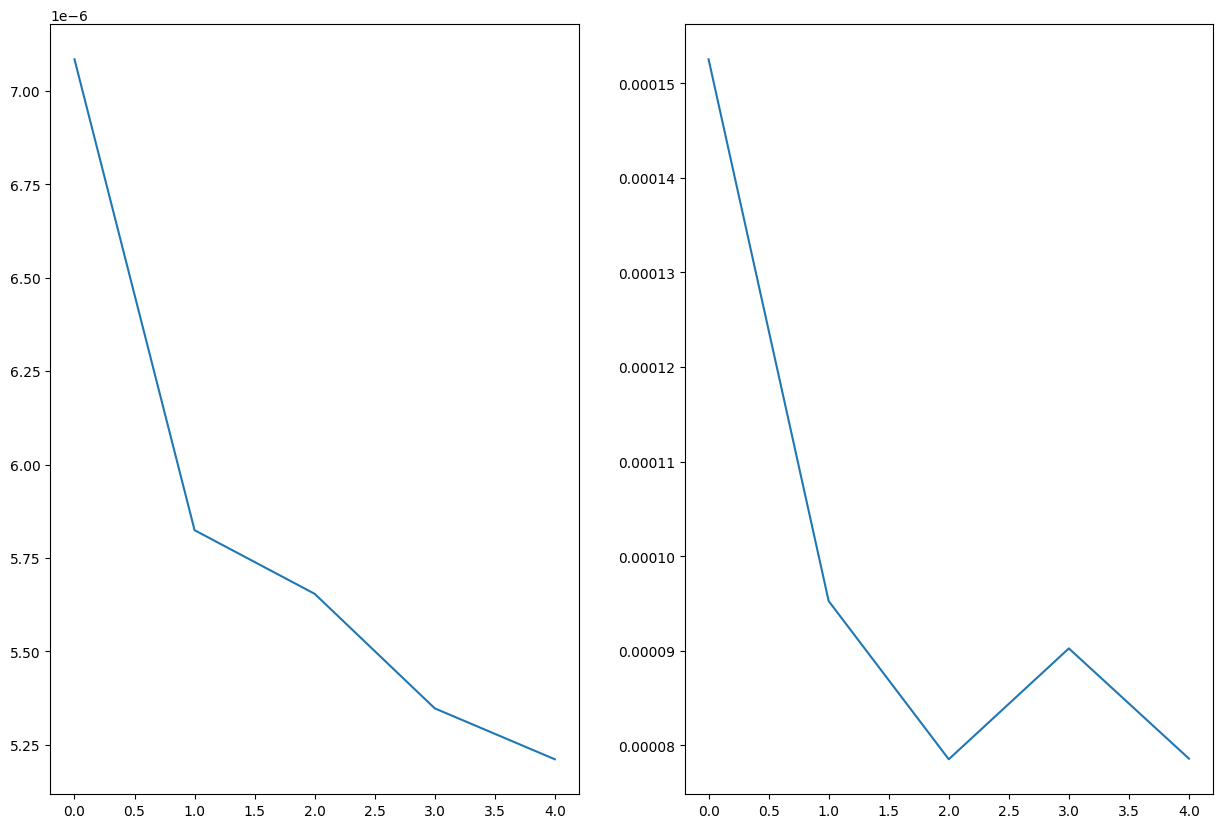

In [28]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(np.array([totalLogInitPlusPlus[i]["tCentroids"] for i in range(n_samples)]).mean(axis=1))
ax[1].plot(np.array([totalLogInitPlusPlus[i]["tSamples"] for i in range(n_samples)]).mean(axis=1))
#ax[2].plot(logParallelInit["CostInit"])

In [37]:
pprint.pprint(totalLogKmeansPlusPlus)

{0: {'CostsKmeans': [np.float64(5288285.729570422),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
                     np.float64(5252490.862321499),
            

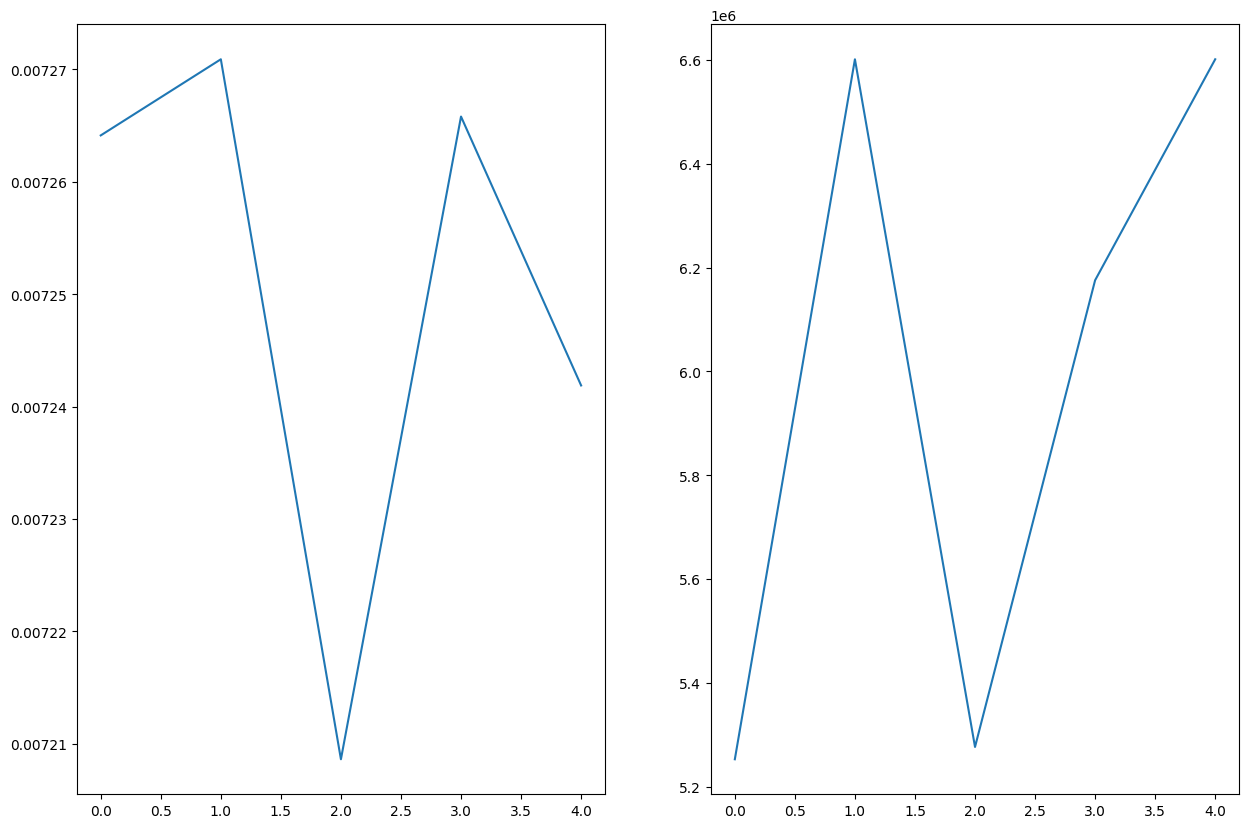

In [39]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(np.array([totalLogKmeansPlusPlus[i]["tIterations"] for i in range(n_samples)]).mean(axis=1))
ax[1].plot(np.array([totalLogKmeansPlusPlus[i]["CostsKmeans"] for i in range(n_samples)]).mean(axis=1))

# Added Performance comparison between kMeans++ and kMeans//, for a small size datatset. For now, i just consider times and not costs (can be added). Also, we need to insert a convergence stopping condition so to compare the two performances actually (the TOTAL time up to convergence, not just the time for a fixed n of iterations)